## Demo: Denoising of 2D Mouse Brain Cortex Images
This notebook demonstrates applying an EMDiffuse-n model for a 2D denoising task. In this example, we will use [EMDiffuse-n model](https://connecthkuhk-my.sharepoint.com/personal/u3590540_connect_hku_hk/_layouts/15/onedrive.aspx?ga=1&id=%2Fpersonal%2Fu3590540%5Fconnect%5Fhku%5Fhk%2FDocuments%2FEMDiffuse%5Fmodel%5Fweight%2FEMDiffuse%2Dn) trained on mouse brain cortex denoise dataset. 

The trained model is assumed to be located in the folder ``experiments`` with the name `EMDiffuse-n`. 
The example image is stored in `demo/denoise_demo.tif`.

The diffusion process on the CPU is relatively slow. So, it is recommended that prediction be run on GPU. 

## Download and Install EMDiffuse

In [ ]:
!git clone https://github.com/Luchixiang/EMDiffuse
%cd EMDiffuse/
!pip install -r requirements.txt

Note: Before starting, ensure that you're working within the 'EMDiffuse' directory. The directory can be checked with the `!pwd` command and adjusted with the `%cd` command. 

In [1]:
#!pwd
#%cd ../..

/home/cxlu/EMDiffuse/example/denoise
/home/cxlu/EMDiffuse


In [2]:
import core.praser as Praser
import os
import warnings
import torch
import cv2
import torch.multiprocessing as mp
from tifffile import imread
from crop_single_file import crop
from core.logger import VisualWriter, InfoLogger
import core.praser as Praser
import core.util as Util
from data import define_dataloader
from models import create_EMDiffuse
from emdiffuse_conifg import EMDiffuseConfig
import matplotlib.pyplot as plt

## Crop the Test Image
Given the constraints of GPU memory capacity, it's necessary to segment larger images into smaller patches before processing. Here are the specific parameters to consider when segmenting the image:

- img: The numpy image array. 
- crop_save_path: The directory where the resulting image patches will be saved. 
- patch_size: The dimensions of patches. As a general rule, use a patch size with a power of two along all axes or at least divisible by 8. For this example, we will use patches of 256x256.
- overlap: Overlap ratio of adjacent patches. For this example, we use an overlap ratio of 0.125 (i.e., 32 pixels).
 

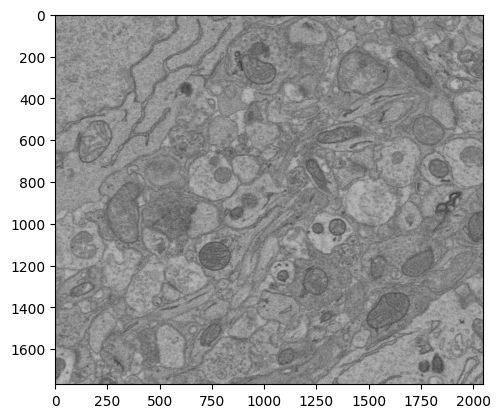

In [3]:
img = cv2.imread('./demo/denoise_demo.tif')
plt.imshow(img, cmap='gray')
crop_save_path = os.path.join('./demo', 'denoise_crop_patches', 'cell_1', 'noise_1')
os.makedirs(crop_save_path, exist_ok=True)
crop(img, crop_save_path, patch_size=256, overlap=0.125)

## Show Example Cropped Data

Text(0.5, 1.0, 'Example 2')

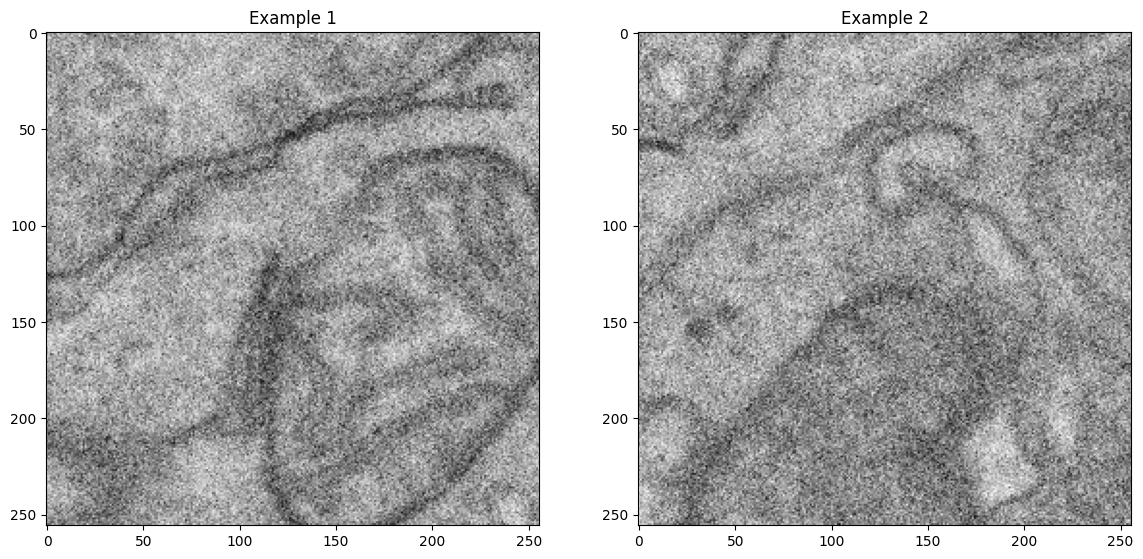

In [4]:
example_image_noise1 = imread(os.path.join(crop_save_path, '2_0.tif'))
example_image_noise2 = imread(os.path.join(crop_save_path, '3_1.tif'))
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(example_image_noise1, cmap='gray')
plt.title('Example 1')
plt.subplot(1,2,2)
plt.imshow(example_image_noise2, cmap='gray')
plt.title('Example 2')

## Download the Pretrained Model Weight

In [5]:
import urllib
import zipfile
if not os.path.isdir('./experiments'):
    os.mkdir('./experiments')

# Download the model weight trained on the mouse brain cortex denoise dataset. Skip this step if you prefer to use your own trained model.
zipPath="experiments/EMDiffuse-n.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://zenodo.org/records/10686030/files/EMDiffuse-n.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("experiments")

## EMDiffuse-n Model
Load the trained model (located in `experiments` with the name `EMDiffuse-n`) from disk.
When loading the model for testing, we replicate the training configuration with the addition of a few testing-specific parameters:

- batch size: test batch size.

- mean: Diffusion model samples one plausible solution from the learned solution distribution. Mean denotes the number of outputs you want to generate and average. 

- resume: The path to the model's weights file and the epoch number from which to load the model.
- step: The number of diffusion steps. More steps, higher image quality. 

In [6]:
config = EMDiffuseConfig(config='config/EMDiffuse-n.json', phase='test', 
                         path='./demo/denoise_crop_patches', batch_size=16, mean=1, resume='./experiments/EMDiffuse-n/best', step=200)
opt = Praser.parse(config) # Parse the config
opt['world_size'] = 1 
Util.set_seed(opt['seed'])
model = create_EMDiffuse(opt)
print(f'len test data loader: {len(model.phase_loader)}')

results and model will be saved in experiments/test_EMDiffuse-n_240221_201043
len test data loader: 4


## Testing

The denoised images and logger information are automatically saved within a newly created directory as logged above. If you find the results are total noise image, it is mostly likely because you didn't load the model weight properly.

In [7]:
model.test()

sampling loop time step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 51.65it/s]


## Show Some Denoised Results 

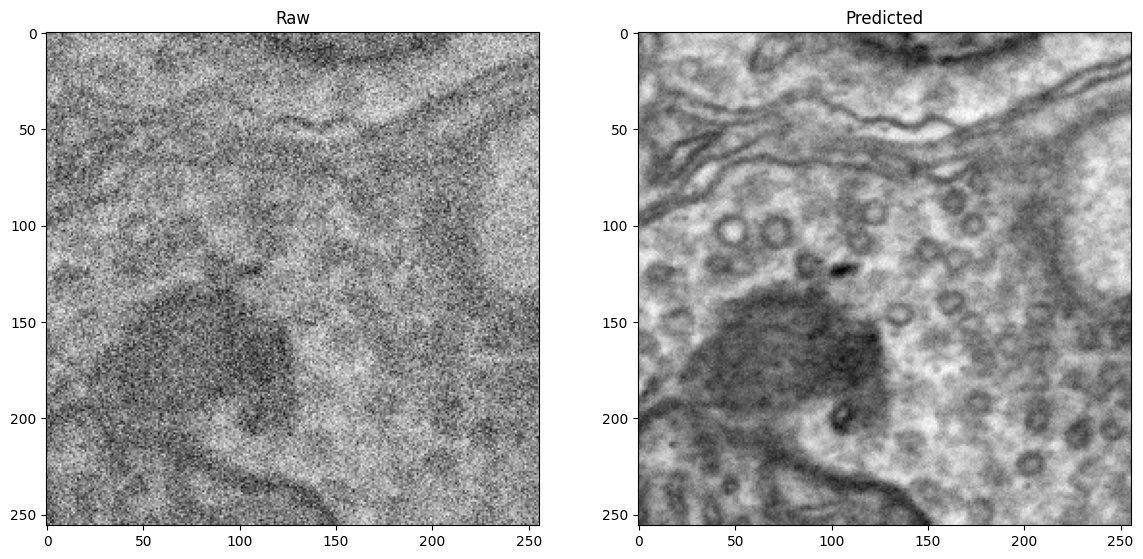

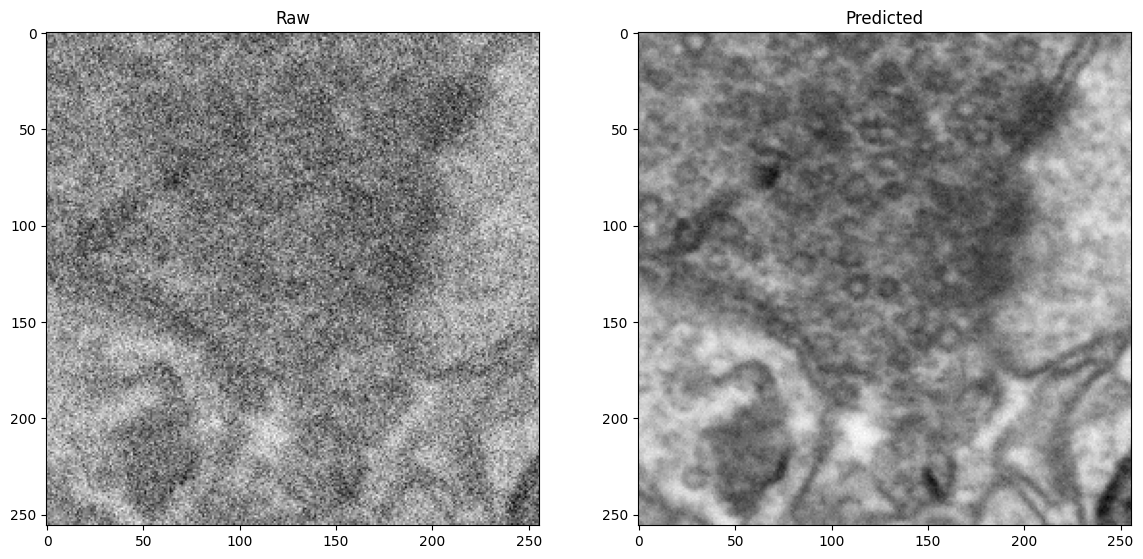

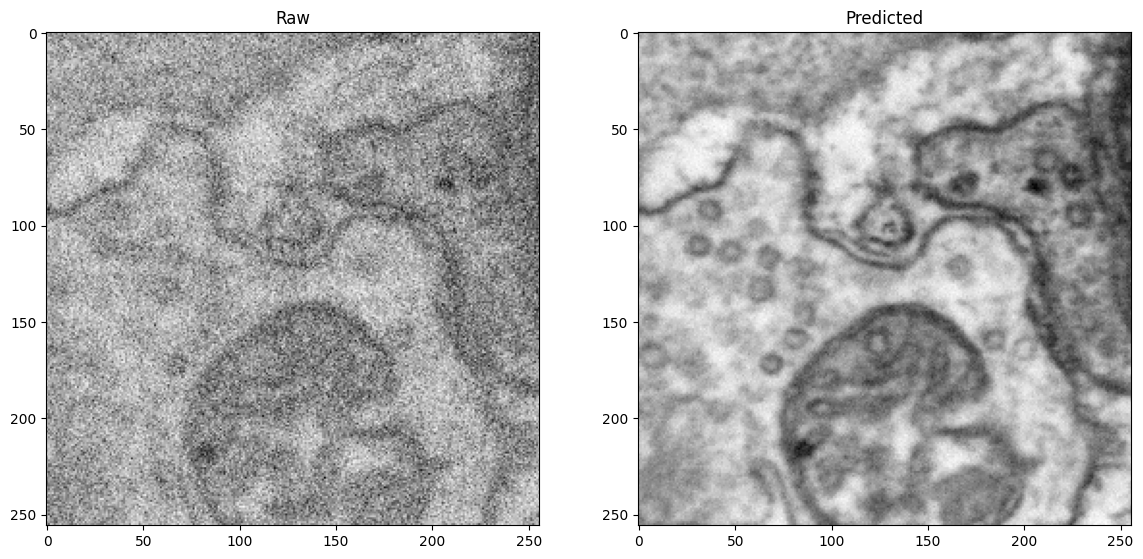

In [8]:
import glob
results_path = os.path.join(opt['path']['experiments_root'], 'results', 'test', '0')
noisy_images = glob.glob(os.path.join(results_path, 'Input_*.tif'))
if len(noisy_images) != 0:
    for i in range(3):
        noisy_img =  imread(noisy_images[i])
        denoised_img = imread(noisy_images[i].replace('Input', 'Out'))
        plt.figure(figsize=(14,7))
        plt.subplot(1,2,1)
        plt.imshow(noisy_img, cmap='gray')
        plt.title('Raw')
        plt.subplot(1,2,2)
        plt.imshow(denoised_img, cmap='gray')
        plt.title('Predicted')